# At Home Solar Charging notebooks: Exploring how EV charging aligns with rooftop solar generation by homes

<p>We will be using Pecan Street Inc. data from dataport to determine how electric vehicle charging aligns with rooftop solar generation.<br><br>
Pecans Streets data can be obtained by applying for a dataport account at https://www.dataport.pecanstreet.org.</p>


In [1]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import sqlalchemy as sqla
import os
from config.read_config import get_database_config
import numpy as np
import sys
%matplotlib inline
sys.executable  # shows you your path to the python you're using

'/usr/bin/python3.8'

In [2]:
# read in db credentials from config/config.txt
# * make sure you add those to the config/config.txt file! *

database_config = get_database_config("./config/config.txt")

In [3]:
# get our DB connection
engine = sqla.create_engine('postgresql://{}:{}@{}:{}/{}'.format(database_config['username'],
                                                                     database_config['password'],
                                                                     database_config['hostname'],
                                                                     database_config['port'],
                                                                     database_config['database']
                                                                     ))

In [4]:
#Select a list of Texas homes from dataport metadata having CAR and solar configured and also has data for year 2018.
query = """select distinct dataid from other_datasets.metadata 
                                          where car1='yes' and solar='yes' 
                                          and egauge_1min_min_time < '2018-01-01' 
                                          and egauge_1min_max_time > '2019-01-01'
                                          and state='Texas'
                                          and (egauge_1min_data_availability like '100%' 
                                               or 
                                               egauge_1min_data_availability like '99%');
         """

df = pd.read_sql_query(sqla.text(query), engine)

In [5]:
# grab dataids and convert them to a string to put into the SQL query
dataids_list = df['dataid'].tolist()
print("{} dataids selected listed here:".format(len(dataids_list)))
dataids_str = ','.join(list(map(str, dataids_list)))
dataids_str
dataids_list

24 dataids selected listed here:


[114,
 379,
 1169,
 1354,
 2814,
 3368,
 3829,
 3967,
 5109,
 5357,
 5450,
 5749,
 6139,
 6248,
 6691,
 7024,
 7850,
 7989,
 8142,
 8645,
 8857,
 9647,
 9776,
 9932]

In [6]:
#Check data completeness for dataids selected from metadata above.

query2 = """select dataid,count(*) total_rec from electricity.eg_realpower_1min 
            where dataid in ({})""".format(dataids_str)
query2 = query2 + """ and localminute >= '2018-01-01' and localminute < '2019-01-01' group by 1"""

df2 = pd.read_sql_query(sqla.text(query2), engine)

In [7]:
#Select homes with atleast 99% data availability for year 2018.
df2['perc'] = (df2['total_rec']/525600)*100
final_dataids = df2[df2['perc'] >= 99]
final_dataids['dataid'].count()

23

In [8]:
# Pull data for homes
final_dataids_list = final_dataids['dataid'].tolist()
print("{} dataids selected listed here:".format(len(final_dataids_list)))
final_dataids_str = ','.join(list(map(str, final_dataids_list)))
final_dataids_str
final_dataids_list

23 dataids selected listed here:


[114,
 379,
 1169,
 1354,
 2814,
 3368,
 3829,
 3967,
 5109,
 5357,
 5450,
 5749,
 6139,
 6248,
 6691,
 7024,
 7850,
 7989,
 8142,
 8645,
 9647,
 9776,
 9932]

In [9]:
#fall
fall = """select localminute::timestamp,car1,solar,grid 
               from electricity.eg_realpower_1min 
               where localminute >= '2018-09-01' and localminute <  '2018-12-01' """
fall = fall + """AND dataid in ({})""".format(final_dataids_str)

fall_df = pd.read_sql_query(sqla.text(fall), engine)

fall_df.head(15)

,localminute,car1,solar,grid
0,2018-11-13 20:38:00,0.000,-0.005,0.973
1,2018-10-14 13:10:00,0.003,0.596,2.467
2,2018-10-15 21:50:00,0.000,-0.006,1.339
3,2018-10-15 22:50:00,0.000,-0.001,0.672
4,2018-10-16 18:10:00,0.000,-0.012,0.949
5,2018-10-16 20:15:00,0.000,-0.009,1.430
6,2018-10-17 01:27:00,0.098,-0.002,0.733
7,2018-10-17 07:46:00,0.000,-0.007,1.102
8,2018-10-18 18:48:00,0.079,-0.005,0.968
9,2018-10-20 11:14:00,0.064,0.323,1.451


In [10]:
#spring
spring = """select localminute::timestamp,car1,solar,grid 
               from electricity.eg_realpower_1min 
               where localminute >= '2018-03-01' and localminute <  '2018-06-01' """
spring = spring + """AND dataid in ({})""".format(final_dataids_str)

spring_df = pd.read_sql_query(sqla.text(spring), engine)

In [11]:
#summer
summer = """select localminute::timestamp,car1,solar,grid 
               from electricity.eg_realpower_1min 
               where localminute >= '2018-06-01' and localminute <  '2018-09-01' """
summer = summer + """AND dataid in ({})""".format(final_dataids_str)

# create a dataframe with the data from the sql query
summer_df = pd.read_sql_query(sqla.text(summer), engine)

In [12]:
#winter
winter = """select localminute::timestamp,car1,solar,grid 
               from electricity.eg_realpower_1min 
               where localminute >= '2018-12-01' and localminute <  '2019-03-01' """
winter = winter + """AND dataid in ({})""".format(final_dataids_str)

# create a dataframe with the data from the sql query
winter_df = pd.read_sql_query(sqla.text(winter), engine)

In [13]:
# data analysis for summer

#replace null with 0's
summer_df = summer_df.fillna(0)
# convert localminute to pandas daytime type
summer_df['datetime'] = pd.to_datetime(summer_df['localminute'])

summer_df = summer_df.set_index('datetime')

#create hour column
summer_df['hr'] = summer_df.index.hour

#create new dataframes with solar, car1, and hour column
summer_df_new = pd.DataFrame(summer_df, columns = ['solar', 'car1', 'hr'])

# group data based on hour and get avg
summer_df_grouped = summer_df_new.groupby(['hr']).mean()
plot_summer = summer_df_grouped.reset_index()

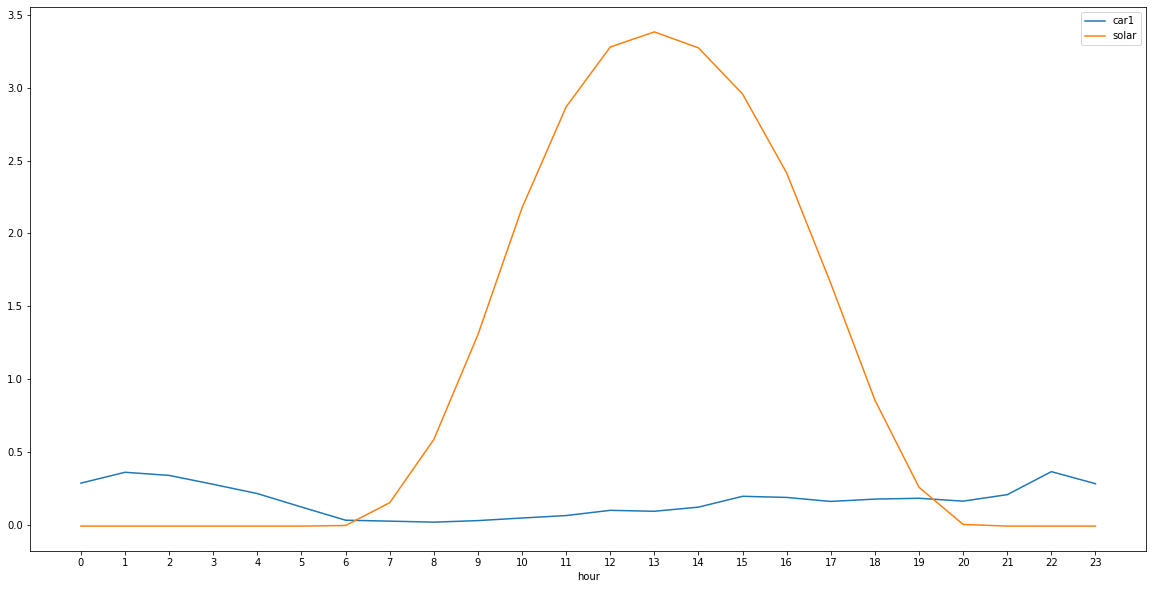

In [15]:
# plot summer
plt.figure(figsize=(20,10))
plt.plot(plot_summer['hr'], plot_summer['car1'], label="car1")
plt.plot(plot_summer['hr'], plot_summer['solar'], label="solar")
plt.xticks(np.arange(0, 24, 1.0))
plt.xlabel('hour')
plt.legend()

plt.show()

In [17]:
# Total car1 usuage powered by solar in summer
total_car1_summer = summer_df_new['car1'].sum()
solar_car1_summer = summer_df_new.loc[summer_df_new['car1'] < summer_df_new['solar'], 'car1'].sum()

car1_powered_by_solar_summer = (solar_car1_summer/total_car1_summer) * 100
car1_powered_by_solar_summer

5.032481093509988

In [18]:
# data analysis for fall

#replace null with 0's
fall_df = fall_df.fillna(0)
# convert localminute to pandas daytime type
fall_df['datetime'] = pd.to_datetime(fall_df['localminute'])

fall_df = fall_df.set_index('datetime')

#create hour column
fall_df['hr'] = fall_df.index.hour

#create new dataframes with solar, car1, and hour column
fall_df_new = pd.DataFrame(fall_df, columns = ['solar', 'car1', 'hr'])

# group data based on hour and get avg
fall_df_grouped = fall_df_new.groupby(['hr']).mean()
plot_fall = fall_df_grouped.reset_index()

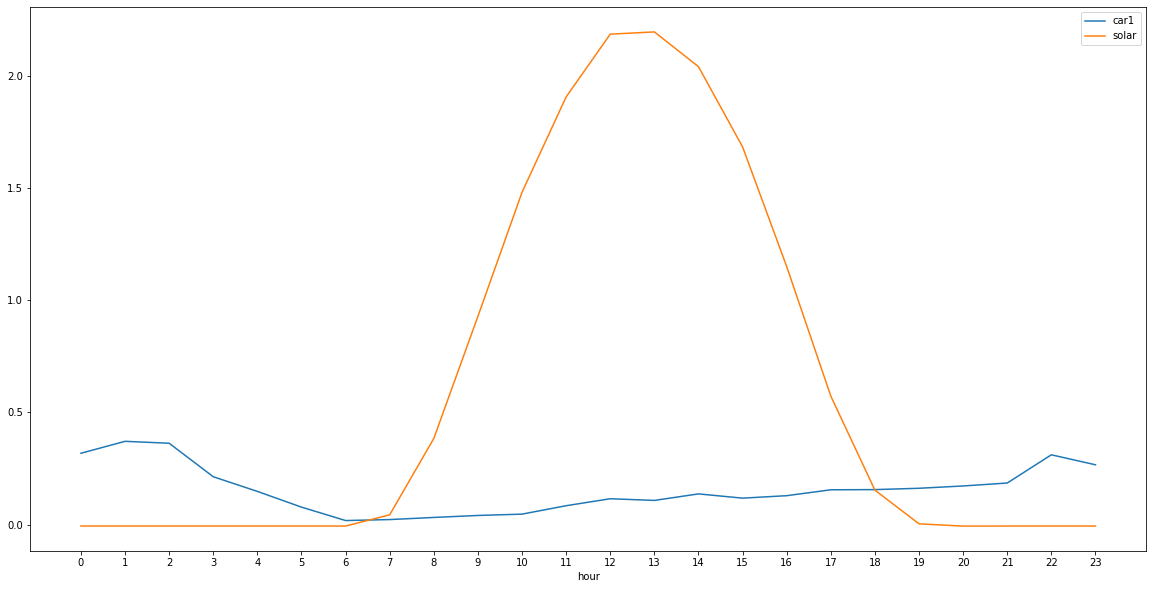

In [19]:
# plot fall
plt.figure(figsize=(20,10))
plt.plot(plot_fall['hr'], plot_fall['car1'], label="car1")
plt.plot(plot_fall['hr'], plot_fall['solar'], label="solar")
plt.xticks(np.arange(0, 24, 1.0))
plt.xlabel('hour')
plt.legend()

plt.show()

In [22]:
# Total car1 usuage powered by solar in fall
total_car1_fall = fall_df_new['car1'].sum()
solar_car1_fall = fall_df_new.loc[fall_df_new['car1'] < fall_df_new['solar'], 'car1'].sum()

car1_powered_by_solar_fall = (solar_car1_fall/total_car1_fall) * 100
car1_powered_by_solar_fall

3.4360061993713615

In [23]:
#data analysis for spring

#replace null with 0's 
spring_df = spring_df.fillna(0)


# convert localminute to pandas datetime type
spring_df['datetime'] = pd.to_datetime(spring_df['localminute'])

spring_df = spring_df.set_index('datetime')

#create hour column. We will be calculating average hourly load for spring.
spring_df['hr'] = spring_df.index.hour

#create new dataframes with only solar, car1 and hour column
spring_df_new = pd.DataFrame(spring_df, columns = ['solar', 'car1','hr'])

#group data based on hour and take avg
spring_df_grouped = spring_df_new.groupby(['hr']).mean()
plot_spring = spring_df_grouped.reset_index()

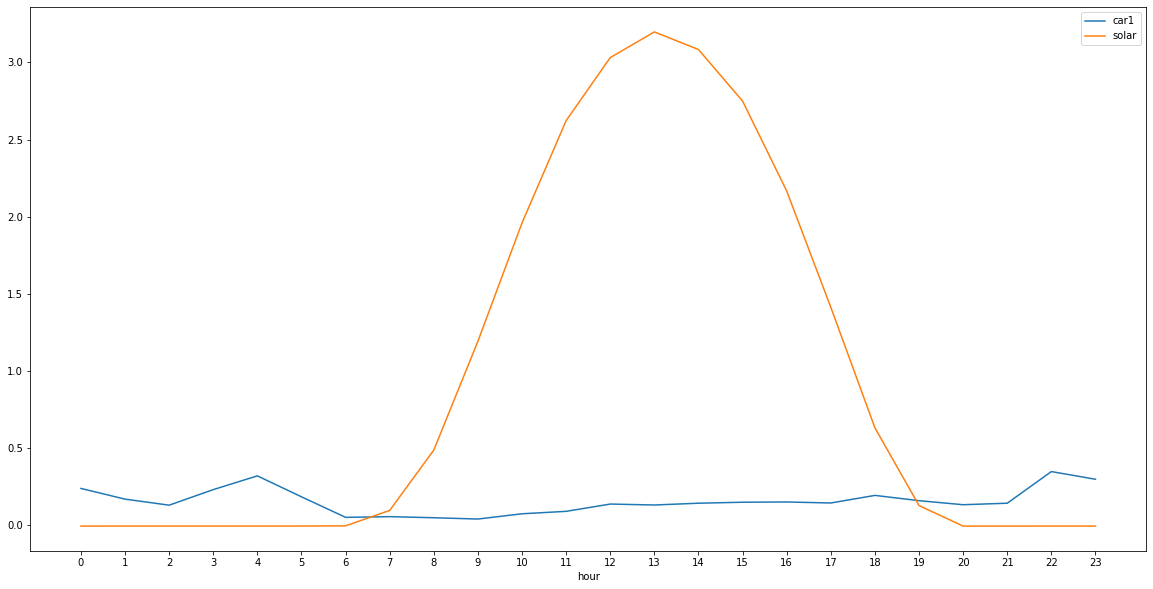

In [24]:
#plot spring
plt.figure(figsize=(20,10))
plt.plot(plot_spring['hr'],plot_spring['car1'],label="car1")
plt.plot(plot_spring['hr'],plot_spring['solar'],label="solar")
plt.xticks(np.arange(0, 24, 1.0))
plt.xlabel('hour')
plt.legend()

plt.show()

In [25]:
#Total car1 usage powered by PV system in spring
total_car1_spring = spring_df_new['car1'].sum()
solar_car1_spring = spring_df_new.loc[spring_df_new['car1'] < spring_df_new['solar'], 'car1'].sum()

car1_powered_by_solar_spring = (solar_car1_spring/total_car1_spring)*100
car1_powered_by_solar_spring

6.910046140695417

In [26]:
#data analysis for winter

#replace null with 0's 
winter_df = winter_df.fillna(0)

# convert localminute to pandas datetime type
winter_df['datetime'] = pd.to_datetime(winter_df['localminute'])

winter_df = winter_df.set_index('datetime')

#create hour column. We will be calculating average hourly load for winter.
winter_df['hr'] = winter_df.index.hour

#create new dataframes with only solar, car1 and hour column
winter_df_new = pd.DataFrame(winter_df, columns = ['solar', 'car1','hr'])

#group data based on hour and take avg
winter_df_grouped = winter_df_new.groupby(['hr']).mean()
plot_winter = winter_df_grouped.reset_index()

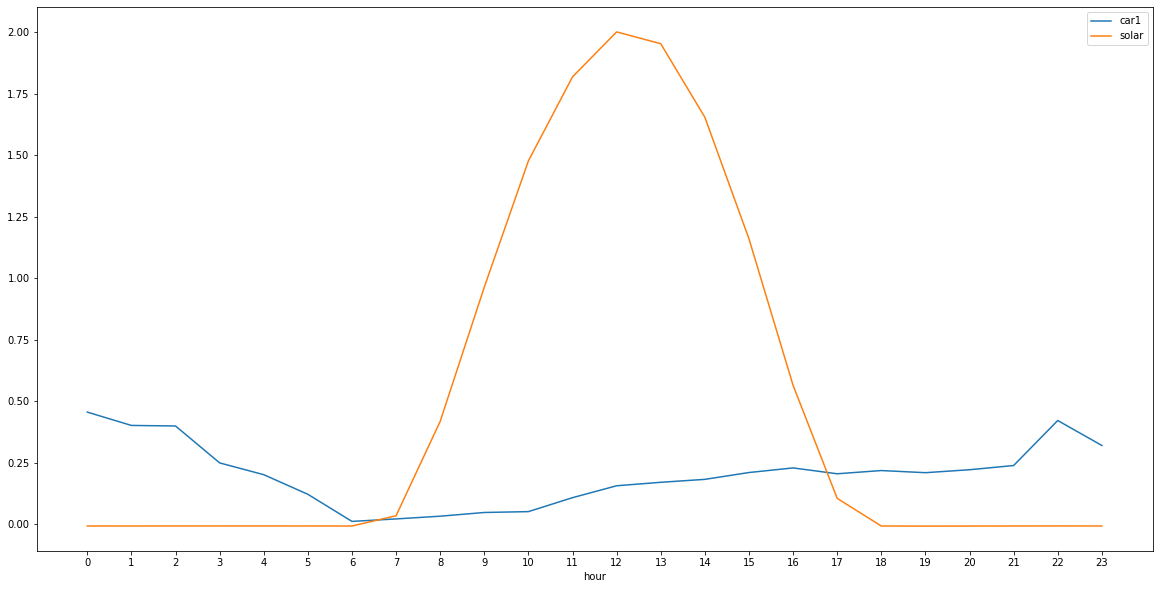

In [27]:
#plot winter
plt.figure(figsize=(20,10))
plt.plot(plot_winter['hr'],plot_winter['car1'],label="car1")
plt.plot(plot_winter['hr'],plot_winter['solar'],label="solar")
plt.xticks(np.arange(0, 24, 1.0))
plt.xlabel('hour')
plt.legend()

plt.show()

In [28]:
#Total car1 usage powered by PV system in winter
total_car1_winter = winter_df_new['car1'].sum()
solar_car1_winter = winter_df_new.loc[winter_df_new['car1'] < winter_df_new['solar'], 'car1'].sum()

car1_powered_by_solar_winter = (solar_car1_winter/total_car1_winter) * 100
car1_powered_by_solar_winter

3.1933175941614156

## Observations:
From the above graphs through out the year most homes started EV charging arount 9PM to 9:30PM and ended charging around 6AM (outside of solar peak hours). the average percentage of solar powered used for EV charging is around 4.51